In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve 

In [2]:
# 데이터 불러오기
X_train = pd.read_csv("../data/X_train.csv")
X_val   = pd.read_csv("../data/X_val.csv")
X_test  = pd.read_csv("../data/X_test.csv")

# 컬럼명 벨류에러로 특수문자 제거
for df in [X_train, X_val, X_test]:
    df.columns = df.columns.str.replace(r"[^A-Za-z0-9_]+", "_", regex=True)

y_train = pd.read_csv("../data/y_train.csv").iloc[:, 0].values.ravel()
y_val   = pd.read_csv("../data/y_val.csv").iloc[:, 0].values.ravel()
y_test  = pd.read_csv("../data/y_test.csv").iloc[:, 0].values.ravel()


In [3]:
# Train + Validation 합치기
X_final = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_final = np.concatenate([y_train, y_val])

In [4]:
# XGBoost 모델 학습 (최적 하이퍼파라미터 반영)
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    eval_metric="logloss",
    random_state=42
)
xgb.fit(X_final, y_final)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [5]:
# 최적 threshold 찾기 (Validation 기준)
val_proba = xgb.predict_proba(X_val)[:, 1]
fpr, tpr, thr = roc_curve(y_val, val_proba)

# F1 기준 최적 threshold 계산
from sklearn.metrics import f1_score
f1_scores = [f1_score(y_val, (val_proba >= t).astype(int)) for t in thr]
best_thr = thr[np.argmax(f1_scores)]
print("최적 threshold:", best_thr)

최적 threshold: 0.38492268


In [6]:
# 성능 평가
test_proba = xgb.predict_proba(X_test)[:, 1]
y_pred_test = (test_proba >= best_thr).astype(int)

print("\n=== Confusion Matrix (Test) ===")
print(confusion_matrix(y_test, y_pred_test))

print("\n=== Classification Report (Test) ===")
print(classification_report(y_test, y_pred_test, digits=4))


=== Confusion Matrix (Test) ===
[[1412   18]
 [  39  155]]

=== Classification Report (Test) ===
              precision    recall  f1-score   support

           0     0.9731    0.9874    0.9802      1430
           1     0.8960    0.7990    0.8447       194

    accuracy                         0.9649      1624
   macro avg     0.9345    0.8932    0.9125      1624
weighted avg     0.9639    0.9649    0.9640      1624



In [7]:
import joblib

# 모델 저장
joblib.dump(xgb, "../models/xgb_machine_failure.pkl")

['../models/xgb_machine_failure.pkl']

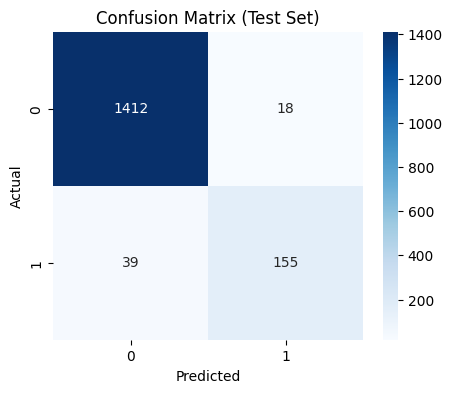

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")
plt.show()

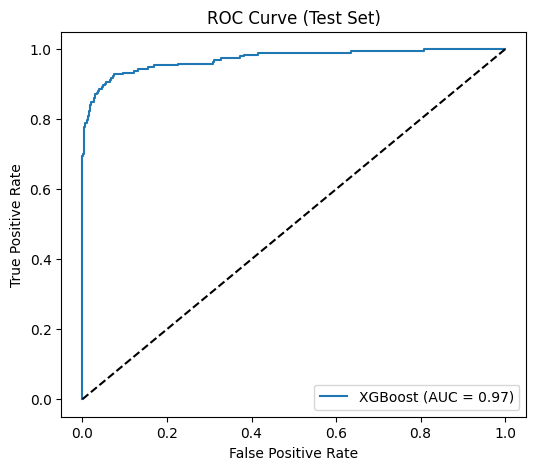

In [9]:
from sklearn.metrics import roc_curve, auc

y_proba_test = xgb.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend(loc="lower right")
plt.show()

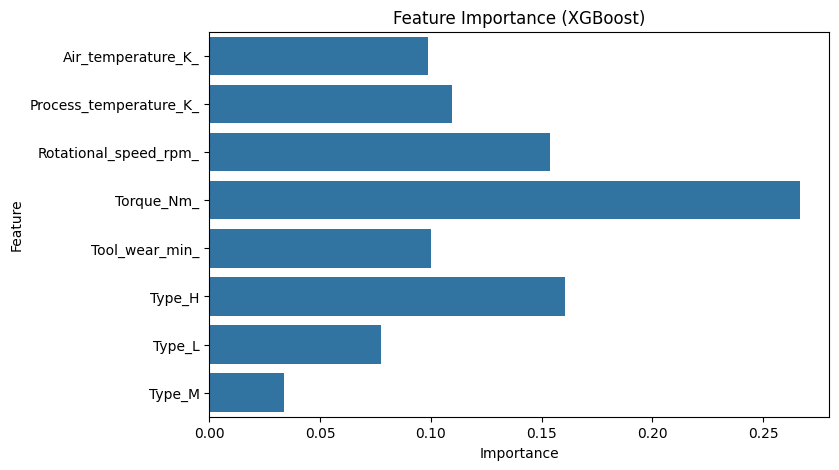

In [10]:
importances = xgb.feature_importances_
features = X_train.columns

plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()